In [78]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
from sklearn.metrics import mean_squared_error as RMSE
import transbigdata as tbd
import seaborn as sns
import math
warnings.filterwarnings('ignore')

In [79]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [80]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [43]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [81]:
train = []
all_files = [f for f in os.listdir('./data/training/')]
trip_id = 0

# build a file name list to remember all the unique taxi
taxi_id_dic = {}
count = 0
for i in all_files:
    taxi_id_dic[i] = count
    count += 1
    
# load training data
for i in all_files:
    taxi = pd.read_csv(os.path.join('./data/training/', i), sep=" ", index_col=None, header=None, 
                      names=['latitude', 'longitude', 'occupancy', 'time'])
    taxi.loc[:, ["time"]] = pd.to_datetime(taxi.time, origin="unix", unit='s')
    taxi.insert(0, "VehicleNum", 0, True)
    taxi.rename(columns = {'VehicleNum':'VehicleNum','latitude':'Lat','longitude':'Lng','occupancy':'OpenStatus','time':'Time'}, inplace = True)
    taxi = taxi[['VehicleNum','Time','Lng','Lat','OpenStatus']]
    oddtaxi = tbd.taxigps_to_od(taxi,col = ['VehicleNum','Time','Lng','Lat','OpenStatus'])
    taxi_deliver,taxi_idle = tbd.taxigps_traj_point(taxi,oddtaxi,col=['VehicleNum', 'Time', 'Lng', 'Lat', 'OpenStatus'])
    j = 0
    while not (taxi_deliver[taxi_deliver['ID'] == j].empty):
        taxi_trip = taxi_deliver[taxi_deliver['ID'] == j]
        duration = (taxi_trip['Time'].iloc[-1] - taxi_trip['Time'].iloc[0]).total_seconds()
        a_trip = [trip_id, taxi_id_dic[i], taxi_trip['Time'].iloc[0], taxi_trip['Time'].iloc[-1], 1, taxi_trip['Lng'].iloc[0], taxi_trip['Lat'].iloc[0], taxi_trip['Lng'].iloc[-1], taxi_trip['Lat'].iloc[-1], 'N', duration]
        train.append(a_trip)
        j += 1;
        trip_id += 1;
train = pd.DataFrame(train, columns=['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','store_and_fwd_flag','trip_duration'])
print(train)

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0          0          0 2008-05-17 10:08:53 2008-05-17 10:19:11   
1          1          0 2008-05-17 10:24:39 2008-05-17 10:24:39   
2          2          0 2008-05-17 10:53:53 2008-05-17 10:53:53   
3          3          0 2008-05-17 11:09:34 2008-05-17 11:14:10   
4          4          0 2008-05-17 11:22:35 2008-05-17 11:40:43   
...      ...        ...                 ...                 ...   
66772  66772         76 2008-06-08 13:37:10 2008-06-08 13:59:20   
66773  66773         76 2008-06-08 14:14:26 2008-06-08 14:38:28   
66774  66774         76 2008-06-08 14:44:44 2008-06-08 14:46:45   
66775  66775         76 2008-06-08 16:49:52 2008-06-08 16:54:52   
66776  66776         76 2008-06-08 17:06:09 2008-06-08 17:11:12   

       passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                    1        -122.44014         37.76768         -122.41277   
1                    1        -122.

In [82]:
# load test data
test = pd.read_csv('./data/testing/test_student.txt', sep=" ", index_col=None, header=None, 
                   names=['vendor_id', 'pickup_latitude', 'pickup_longitude','pickup_datetime','dropoff_latitude','dropoff_longitude'])
test.loc[:, ["pickup_datetime"]] = pd.to_datetime(test.pickup_datetime, origin="unix", unit='s')
test.insert(0, "store_and_fwd_flag", 'N', True)
test.insert(2, "passenger_count", 1, True)
test['vendor_id'] = test['vendor_id'].map(taxi_id_dic)
print(test)

     store_and_fwd_flag  vendor_id  passenger_count  pickup_latitude  \
0                     N         45                1         37.61564   
1                     N         45                1         37.62060   
2                     N         45                1         37.76160   
3                     N         45                1         37.76731   
4                     N         45                1         37.78554   
...                 ...        ...              ...              ...   
1896                  N          7                1         37.78171   
1897                  N          7                1         37.75691   
1898                  N          7                1         37.76412   
1899                  N          7                1         37.79192   
1900                  N          7                1         37.76677   

      pickup_longitude     pickup_datetime  dropoff_latitude  \
0           -122.39190 2008-06-09 16:57:34          37.78373   
1      

In [83]:
# basic feature extraction
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['trip_duration'].max() // 3600
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)

In [47]:
# decide the city size
city_long_border = (-121.5253, -122.8315)
city_lat_border = (37.0530, 38.2554)

# Feature Extraction

In [84]:
# PCA
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
pca_train_1 = time.time()
pca = PCA().fit(coords)
pca_train_2 = time.time()
print("pca train cost %i ms" % ((pca_train_2 - pca_train_1)*1000))


train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

pca train cost 9 ms


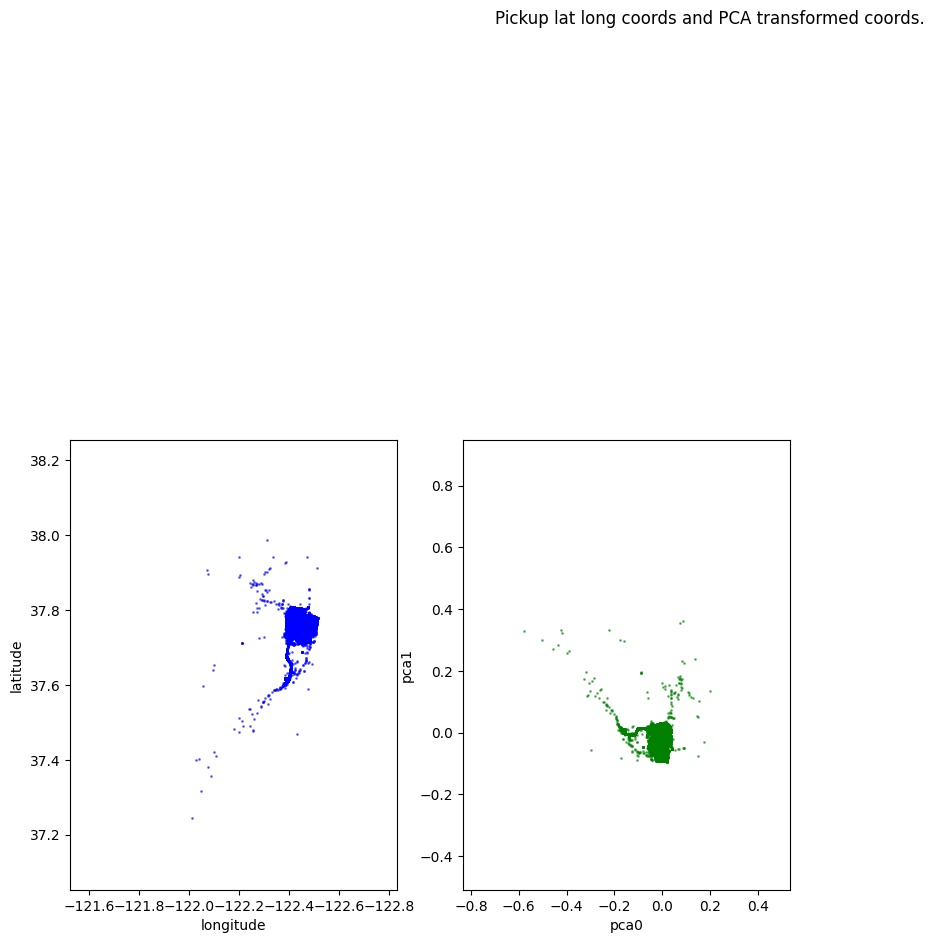

In [85]:
N = 100000
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=0.1, right=0.55, top=0.55, bottom=0.1)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.5)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.5)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

In [86]:
# Distance
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

In [87]:
# Datetime features
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

In [88]:
# Speed
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

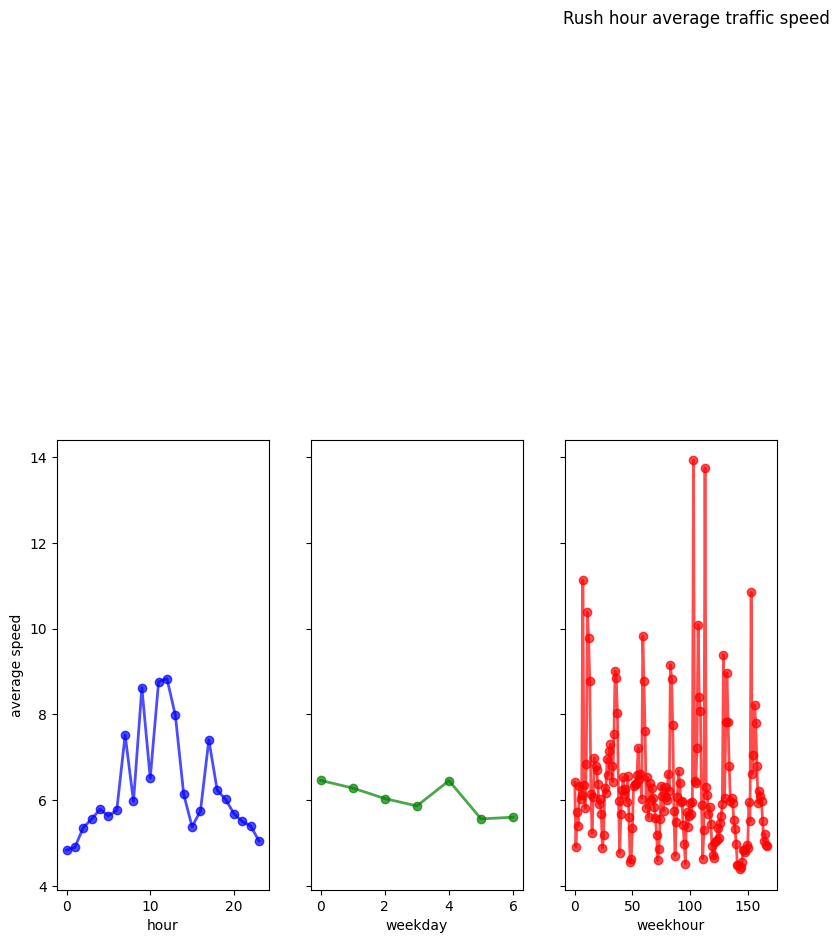

In [96]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
plt.subplots_adjust(left=0.1, right=0.55, top=0.55, bottom=0.1)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

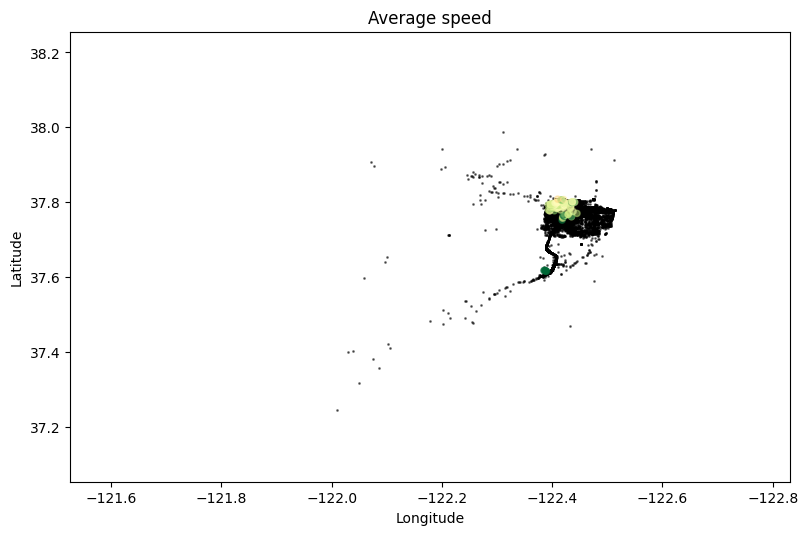

In [98]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
plt.subplots_adjust(left=0.1, right=0.55, top=0.55, bottom=0.1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N],
           color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

In [91]:
# Clustering
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans_train_0 = time.time()
kmeans = KMeans(n_clusters=100, max_iter=100).fit(coords[sample_ind])
kmeans_train_1 = time.time()
print("Kmeans training costs %i ms" % ((kmeans_train_1 - kmeans_train_0) * 1000))


train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

Kmeans training costs 20002 ms


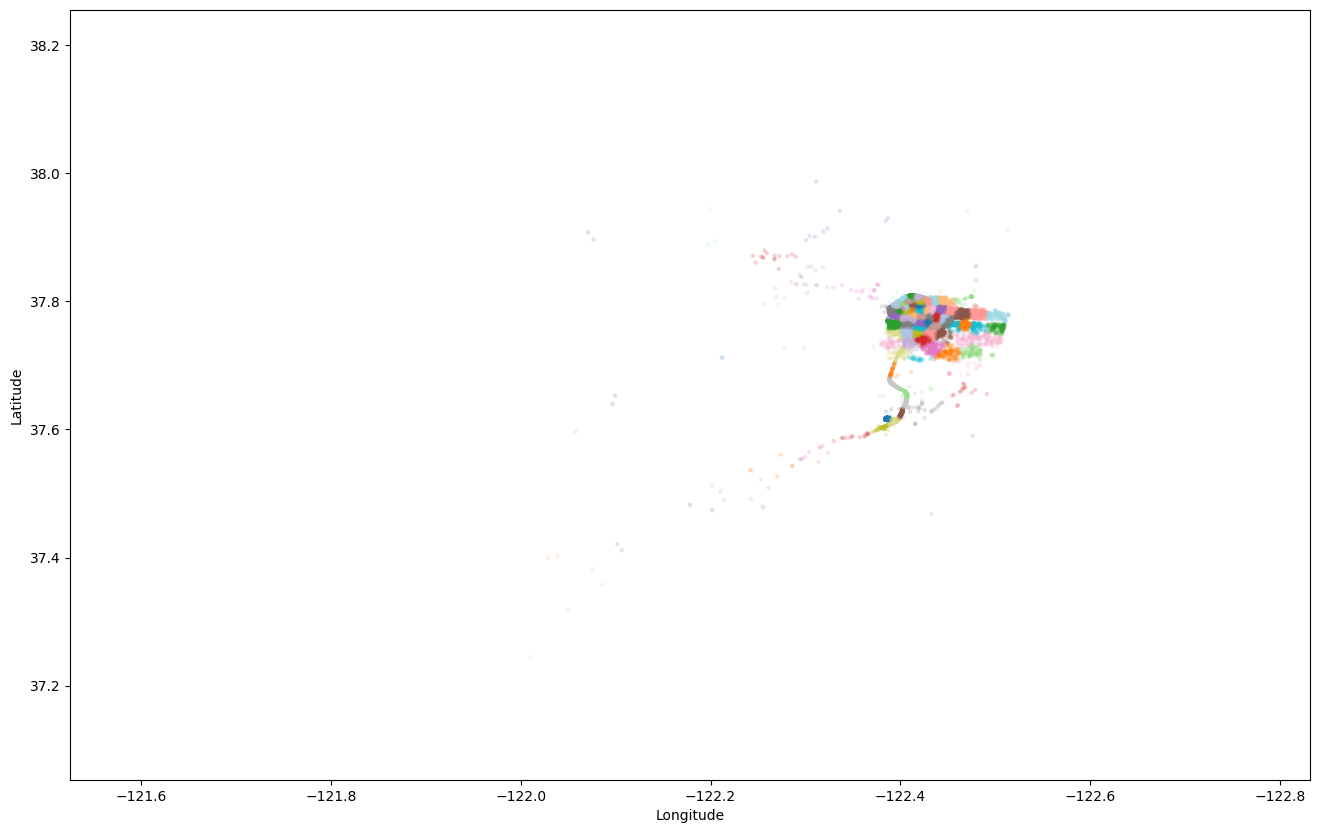

In [92]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [93]:
# Temporal aggregation
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

In [95]:
feature_names = list(train.columns)
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'pickup_date', 'avg_speed_h', 'avg_speed_m']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

# t1 = dt.datetime.now()
# print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

We have 45 features.


In [59]:
# OSRM Features
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
35,log_trip_duration_gby_pickup_date,2.564932
27,pickup_dt_bin,3.099266
21,pickup_dt,3.099528
1,passenger_count,NaN
6,store_and_fwd_flag,NaN


In [60]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
26,center_long_bin,0.0,0.000,0.000
6,store_and_fwd_flag,0.0,0.000,0.000
33,avg_speed_h_gby_pickup_date,0.0,0.068,0.068
35,log_trip_duration_gby_pickup_date,0.0,0.068,0.068
34,avg_speed_m_gby_pickup_date,0.0,0.068,0.068


# XGBoost Prediction

In [61]:
# Model
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster': 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear', 'verbosity': 0, 'ntherad': 48}
xgb_train_0 = time.time()
model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)
xgb_train_1 = time.time()
print("xgb train %i ms" % ((xgb_train_1 - xgb_train_0) * 1000))
ypred = model.predict(dvalid)
y = model.predict(dtest)

print("rmse error: ", RMSE(yv, ypred, squared=False))

[0]	train-rmse:4.06333	valid-rmse:4.06676
[10]	train-rmse:0.41879	valid-rmse:0.44100
[20]	train-rmse:0.37456	valid-rmse:0.41414
[30]	train-rmse:0.35708	valid-rmse:0.41212
[40]	train-rmse:0.34455	valid-rmse:0.41082
[50]	train-rmse:0.33610	valid-rmse:0.40957
[59]	train-rmse:0.32838	valid-rmse:0.40933
xgb train 3653 ms
rmse error:  0.40933064406234504


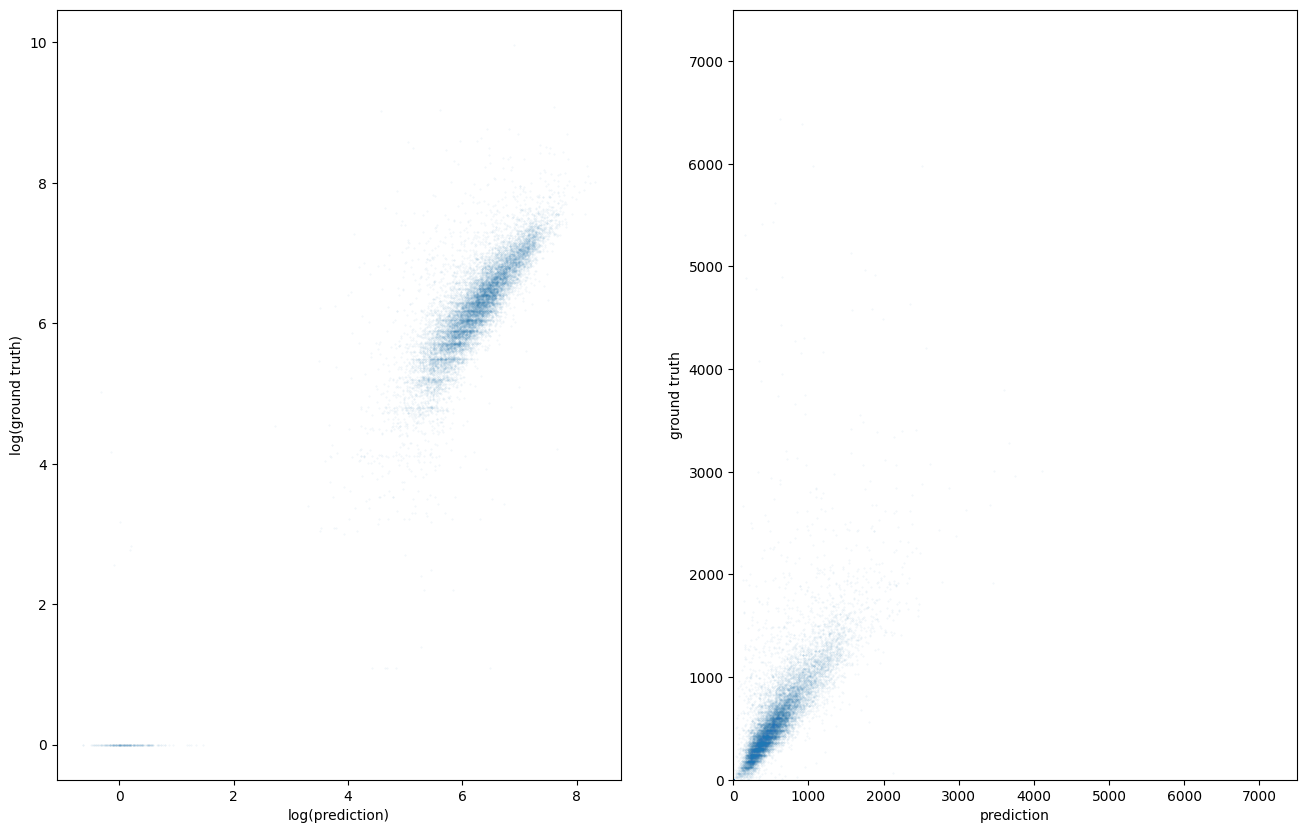

In [62]:
fig,ax = plt.subplots(ncols=2)
ax[0].scatter(ypred, yv, s=0.1, alpha=0.1)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(ground truth)')
ax[1].set_ylim((0, 7500))
ax[1].set_xlim((0, 7500))
ax[1].scatter(np.exp(ypred), np.exp(yv), s=0.1, alpha=0.1)
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('ground truth')
plt.show()

In [63]:
reverse_taxi_id_dic = {}
for item in taxi_id_dic.items():
    key = item[1]
    val = item[0]
    reverse_taxi_id_dic[key] = val
    
test['vendor_id'] = test['vendor_id'].map(reverse_taxi_id_dic)

Test shape OK.
                                     vendor_id  trip_duration
0     edf177ee-7e81-4785-821e-ac3d13094ec9.txt    1125.020874
1     edf177ee-7e81-4785-821e-ac3d13094ec9.txt     954.512207
2     edf177ee-7e81-4785-821e-ac3d13094ec9.txt    1423.155762
3     edf177ee-7e81-4785-821e-ac3d13094ec9.txt    1300.437378
4     edf177ee-7e81-4785-821e-ac3d13094ec9.txt    1003.607361
...                                        ...            ...
1896  daa7da5f-f05c-45e1-80f6-63f8f3a2922c.txt    1963.798706
1897  daa7da5f-f05c-45e1-80f6-63f8f3a2922c.txt     644.700928
1898  daa7da5f-f05c-45e1-80f6-63f8f3a2922c.txt     666.688232
1899  daa7da5f-f05c-45e1-80f6-63f8f3a2922c.txt     629.611206
1900  daa7da5f-f05c-45e1-80f6-63f8f3a2922c.txt     508.947754

[1901 rows x 2 columns]
Valid prediction mean: 6.125
Test prediction mean: 6.584


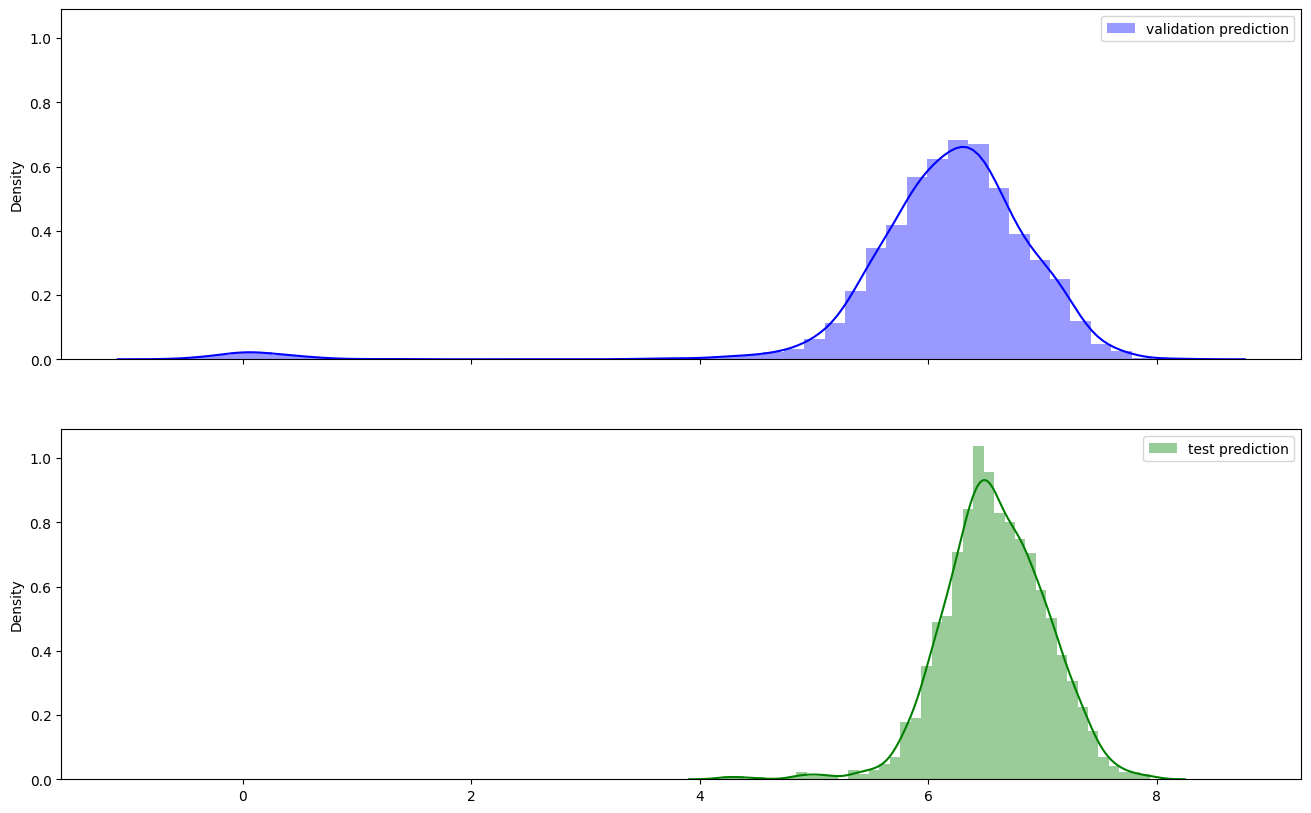

In [64]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['trip_duration'] = np.exp(ytest) - 1

print(test[['vendor_id', 'trip_duration']])
result = test[['vendor_id', 'trip_duration']].to_csv('Xiyang_Shuang.csv', index=False, header=False)


print('Valid prediction mean: %.3f' % ypred.mean())
print('Test prediction mean: %.3f' % ytest.mean())
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(ytest, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()